# 📈 Análise Exploratória (EDA)
## 🔄 Ajuste do Diretório de Trabalho

Antes de carregar ou manipular arquivos, é importante garantir que estamos no diretório correto do projeto.  
O código abaixo verifica se o notebook está sendo executado a partir da pasta `notebooks`. Se for o caso, ele sobe um nível na hierarquia de diretórios para garantir que o diretório de trabalho seja a raiz do projeto.

Isso é útil para manter caminhos relativos consistentes ao acessar dados, scripts ou outros recursos do projeto.

📌 **Resumo do que o código faz:**
- Verifica se o diretório atual termina com `notebooks`.
- Se sim, volta uma pasta (para a raiz do projeto).
- Exibe o novo diretório de trabalho.


In [8]:
import os

# Verifica se o diretório de trabalho atual termina com 'notebooks'
if os.path.basename(os.getcwd()) == 'notebooks':
    # Se sim, sobe um nível de diretório para a pasta raiz do projeto
    os.chdir('..')

# Imprime o diretório de trabalho para confirmar que a mudança foi feita
print(f"Diretório de Trabalho Atual: {os.getcwd()}")

Diretório de Trabalho Atual: c:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov


## ⚙️ Carregamento de Bibliotecas e Configurações do Projeto

Nesta etapa, realizamos a importação das principais bibliotecas que serão utilizadas ao longo do projeto, organizadas por finalidade:

- 📁 **Configurações do Projeto**:  
  Importamos o módulo `src.config`, que armazena configurações como caminhos de arquivos, variáveis globais e parâmetros fixos.

- 📊 **Manipulação de Dados**:  
  - `pandas` e `numpy` para operações de estruturação e análise de dados.  
  - `duckdb` para consultas SQL diretamente em DataFrames.

- ⚙️ **Engenharia de Atributos**:  
  - `pandas_ta` é uma biblioteca especializada para análise técnica, útil para projetos com dados temporais (ex: séries financeiras).

- 📈 **Visualização de Dados**:  
  - `matplotlib.pyplot` e `seaborn` para construção de gráficos interativos e estilizados.

- 🧰 **Helpers do Notebook**:  
  - `display` do `IPython` facilita a visualização de objetos em células do notebook.

Além disso, aplicamos configurações visuais para padronizar os gráficos:
- Tema `whitegrid` do Seaborn.
- Estilo `fivethirtyeight` do Matplotlib.
- Habilitação do modo inline para que os gráficos sejam renderizados dentro do notebook.

```python
print("✅ Bibliotecas carregadas com sucesso!")


In [9]:
# ======================== CONFIGURAÇÕES DO PROJETO ========================
import src.config as config  # Configurações do projeto (ex: caminhos, variáveis de ambiente)

# ======================== MANIPULAÇÃO DE DADOS ============================
import duckdb
import numpy as np
import pandas as pd

# ====================== ENGENHARIA DE ATRIBUTOS ===========================
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler

# ====================== MODELAGEM / MACHINE LEARNING ======================
import lightgbm as lgb
import xgboost as xgb
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning

# ======================= MÉTRICAS E INTERPRETAÇÃO =========================
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score
)
from sklearn.inspection import permutation_importance

# ============================ VISUALIZAÇÃO ================================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================ ESTATÍSTICA ================================
from scipy.stats import norm
import statsmodels.api as sm

# ======================== AMBIENTE NOTEBOOK ===============================
from IPython.display import display
import warnings

# Apenas para notebooks Jupyter:
# %matplotlib inline

print("✅ Bibliotecas carregadas com sucesso!")

✅ Bibliotecas carregadas com sucesso!


## 🧰 Configuração de Estilo e Exibição de Dados

Antes de iniciar a análise, definimos algumas configurações visuais e de exibição para melhorar a legibilidade dos outputs e a consistência gráfica.

### 📊 Configurações do `pandas`
- `max_columns = 100`: Permite visualizar até 100 colunas sem truncamento.
- `max_rows = 100`: Permite visualizar até 100 linhas diretamente no output.
- `float_format = '{:.2f}'`: Formata números decimais com 2 casas, facilitando a leitura.

```python
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
```

In [10]:
# Pandas display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Estilo visual com Seaborn (engloba Matplotlib)
sns.set_theme(
    context='notebook',
    style='whitegrid',
    palette='viridis',
    font='sans-serif',
    font_scale=1.1,
    rc={
        'figure.figsize': (12, 6),
        'font.size': 12,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'lines.linewidth': 2,
        'grid.alpha': 0.3
    }
)

## 🗃️ Carregamento dos Dados - Fase 1

Nesta etapa, conectamos ao banco de dados local gerado na **Fase 1** do pipeline para carregar os dados da tabela `precos_diarios`.

Utilizamos o **DuckDB**, um banco de dados analítico embutido, eficiente para análise local de dados com sintaxe SQL.

📌 **Etapas realizadas:**
1. O caminho do banco de dados (`DB_PATH`) é recuperado do módulo de configurações `config`.
2. Estabelecemos uma conexão com o DuckDB em modo **somente leitura** (`read_only=True`), garantindo integridade.
3. Executamos uma query SQL para obter todos os registros da tabela `precos_diarios`.
4. A conexão é encerrada após a leitura.
5. O dataframe resultante é exibido com:
   - `df.info()` para verificar a estrutura.
   - `df.head()` para visualizar as primeiras linhas.

Em caso de falha, uma mensagem de erro orienta o usuário a verificar se o pipeline da Fase 1 foi executado corretamente e se o arquivo do banco existe no local esperado.


In [11]:
# --- Carregando os dados da Fase 1 ---

# O caminho para o banco de dados já está no nosso módulo 'config'
db_path = str(config.DB_PATH)

print(f"Carregando dados de: {db_path}")

try:
    # Conecta ao banco de dados DuckDB em modo de apenas leitura
    con = duckdb.connect(database=db_path, read_only=True)

    # Executa uma query SQL para selecionar todos os dados da nossa tabela
    df = con.execute("SELECT * FROM features_completas").fetchdf()

    # Fecha a conexão com o banco de dados
    con.close()

    # --- Verificação ---
    print("\n✅ Dados carregados com sucesso! Verificando a estrutura:")
    df.info()

    print("\nExibindo as 5 primeiras linhas:")
    display(df.head())

except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar os dados: {e}")
    print("Verifique se o pipeline da Fase 1 foi executado com sucesso e se o arquivo do banco de dados existe no local correto.")

Carregando dados de: C:\Users\Carlo\Desktop\Portfolio\postech-challenge-ibov\data\mercados.duckdb



✅ Dados carregados com sucesso! Verificando a estrutura:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5313 entries, 0 to 5312
Columns: 161 entries, data to inter_dolar_pos_close_ibov
dtypes: datetime64[ns](1), float64(154), int32(5), object(1)
memory usage: 6.4+ MB

Exibindo as 5 primeiras linhas:


,data,close_petroleo_brent,close_petrobras,close_dolar,close_ibovespa,close_sp500,high_petroleo_brent,high_petrobras,high_dolar,high_ibovespa,high_sp500,low_petroleo_brent,low_petrobras,low_dolar,low_ibovespa,low_sp500,open_petroleo_brent,open_petrobras,open_dolar,open_ibovespa,open_sp500,volume_petroleo_brent,volume_petrobras,volume_sp500,semana_do_mes,target,petroleo_brent_ret_acum_2d,petroleo_brent_ret_acum_5d,petroleo_brent_ret_acum_10d,petroleo_brent_ret_acum_21d,petrobras_ret_acum_2d,petrobras_ret_acum_5d,petrobras_ret_acum_10d,petrobras_ret_acum_21d,dolar_ret_acum_2d,dolar_ret_acum_5d,dolar_ret_acum_10d,dolar_ret_acum_21d,ibovespa_ret_acum_2d,ibovespa_ret_acum_5d,ibovespa_ret_acum_10d,ibovespa_ret_acum_21d,sp500_ret_acum_2d,sp500_ret_acum_5d,sp500_ret_acum_10d,sp500_ret_acum_21d,petroleo_brent_ret_diario,petrobras_ret_diario,dolar_ret_diario,ibovespa_ret_diario,...,tendencia_dolar_medio_prazo_21d,tendencia_ibov_longo_prazo_42d,tendencia_dolar_longo_prazo_42d,tendencia_ibov_longo_prazo_63d,tendencia_dolar_longo_prazo_63d,tendencia_ibov_longo_prazo_126d,tendencia_dolar_longo_prazo_126d,momento_ibov_ultimos_dias_d-1,momento_dolar_ultimos_dias_d-1,momento_ibov_ultimos_dias_d-2,momento_dolar_ultimos_dias_d-2,momento_ibov_ultimos_dias_d-3,momento_dolar_ultimos_dias_d-3,momento_ibov_semana_anterior_d-5,momento_dolar_semana_anterior_d-5,momento_ibov_semana_anterior_d-7,momento_dolar_semana_anterior_d-7,momento_ibov_mes_anterior_d-15,momento_dolar_mes_anterior_d-15,momento_ibov_mes_anterior_d-21,momento_dolar_mes_anterior_d-21,ret_ibov_vs_dolar_1d,spread_ibov_dolar_21d,vol_relativa_5d,ratio_ret_ibov_dolar_1d,ibov_vs_ma20,dolar_vs_ma20,ibov_vs_ma50,dolar_vs_ma50,ibov_vs_ma100,dolar_vs_ma100,ibov_vs_ma200,dolar_vs_ma200,abnormal_ibov_move,ibov_streak,media_movel_alta,dia_semana,preco_vs_ma21,log_volume_ibov,choque_de_volume_log,range_log_ibov,range_log_dolar,gap_log_ibov,pos_close_ibov,pos_close_dolar,sombra_sup_norm_ibov,sombra_inf_norm_ibov,inter_vol_tend_ibov,inter_vol_preco_ibov,inter_dolar_pos_close_ibov
0,2005-03-08,54.59,3.32,2.15,29021.00,1219.43,55.15,3.33,2.17,29452.00,1225.69,53.26,3.30,2.15,28883.00,1218.57,53.87,3.33,2.17,29452.00,1225.31,101554.00,31289600.00,1523090000.00,2,0,0.02,0.06,0.07,0.21,-0.01,0.07,0.09,0.18,0.00,0.00,0.00,0.00,-0.01,0.05,0.09,0.13,-0.00,0.01,0.03,0.01,0.01,-0.01,0.00,-0.01,...,0.00,-0.15,0.00,-0.11,0.00,-0.05,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,-0.14,14.12,-148439691.18,-0.04,0.00,-0.06,0.00,-0.04,0.00,0.20,0.00,0,-0.00,NaN,Tuesday,NaN,0.00,NaN,0.02,0.01,NaN,0.24,0.05,0.00,0.24,0.00,NaN,0.00
1,2005-03-09,54.77,3.26,2.15,28514.00,1207.01,55.65,3.36,2.17,29058.00,1219.43,54.16,3.25,2.15,28381.00,1206.66,54.54,3.29,2.17,29018.00,1219.43,121574.00,28793600.00,1704970000.00,2,0,0.02,0.03,0.07,0.21,-0.03,0.02,0.05,0.16,0.00,0.00,0.00,0.00,-0.03,0.01,0.05,0.11,-0.01,-0.00,0.01,0.00,0.00,-0.02,0.00,-0.02,...,0.00,-0.15,0.00,-0.11,0.00,-0.05,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.02,-0.14,14.12,-176245111.24,-0.04,0.00,-0.06,0.00,-0.04,0.00,0.20,0.00,0,-1.00,NaN,Wednesday,NaN,0.00,NaN,0.02,0.01,-0.00,0.20,0.05,0.06,0.20,0.00,NaN,0.00
2,2005-03-10,53.54,3.18,2.15,28567.00,1209.25,54.62,3.29,2.17,28682.00,1211.23,52.90,3.16,2.15,28049.00,1201.41,54.35,3.27,2.17,28511.00,1207.01,114000.00,38848000.00,1604020000.00,2,0,-0.02,-0.00,0.04,0.18,-0.04,-0.04,-0.01,0.08,0.00,0.00,0.00,0.00,-0.02,-0.00,0.00,0.09,-0.01,-0.00,0.01,0.01,-0.02,-0.03,0.00,0.00,...,0.00,-0.15,0.00,-0.11,0.00,-0.05,0.00,-0.02,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,0.00,-0.14,14.12,18570107.47,-0.04,0.00,-0.06,0.00,-0.04,0.00,0.20,0.00,0,1.00,NaN,Thursday,NaN,0.00,NaN,0.02,0.01,-0.00,0.82,0.05,0.18,0.73,0.00,NaN,0.00
3,2005-03-11,54.43,3.13,2.15,28075.00,1200.08,54.60,3.22,2.17,28932.00,1213.04,52.50,3.11,2.15,28008.00,1198.15,53.60,3.21,2.17,28567.00,1209.25,112324.00,34470400.00,1449820000.00,2,0,-0.01,0.0

## 🗓️ Ajuste do Índice Temporal

Para garantir uma manipulação adequada de séries temporais, realizamos o ajuste da coluna `data`, transformando-a no índice principal do DataFrame.

📌 **Etapas executadas:**
1. Convertida a coluna `'data'` para o tipo `datetime` com `pd.to_datetime()` para garantir que operações temporais funcionem corretamente (ex: resampling, filtros por período).
2. Definida como **índice do DataFrame** com `df.set_index('data', inplace=True)`, substituindo o índice numérico padrão.
3. Exibimos as primeiras linhas para confirmar a alteração, verificando que `'data'` agora aparece como índice à esquerda do DataFrame.

Esse passo é essencial em análises temporais, especialmente para séries de preços, permitindo ordenação cronológica, reamostragem e outras operações baseadas em tempo.


In [12]:
# Garante que a coluna 'data' esteja no formato datetime, caso ainda não esteja
df['data'] = pd.to_datetime(df['data'])


# Define a coluna 'data' como o novo índice do DataFrame
# O inplace=True modifica o DataFrame diretamente
df.set_index('data', inplace=True)

# Exibe as primeiras linhas para confirmar a mudança. 
# Note que 'data' agora está no lugar do índice numérico.
print("✅ Coluna 'data' definida como índice. A estrutura agora é:")
display(df.head())

✅ Coluna 'data' definida como índice. A estrutura agora é:


,close_petroleo_brent,close_petrobras,close_dolar,close_ibovespa,close_sp500,high_petroleo_brent,high_petrobras,high_dolar,high_ibovespa,high_sp500,low_petroleo_brent,low_petrobras,low_dolar,low_ibovespa,low_sp500,open_petroleo_brent,open_petrobras,open_dolar,open_ibovespa,open_sp500,volume_petroleo_brent,volume_petrobras,volume_sp500,semana_do_mes,target,petroleo_brent_ret_acum_2d,petroleo_brent_ret_acum_5d,petroleo_brent_ret_acum_10d,petroleo_brent_ret_acum_21d,petrobras_ret_acum_2d,petrobras_ret_acum_5d,petrobras_ret_acum_10d,petrobras_ret_acum_21d,dolar_ret_acum_2d,dolar_ret_acum_5d,dolar_ret_acum_10d,dolar_ret_acum_21d,ibovespa_ret_acum_2d,ibovespa_ret_acum_5d,ibovespa_ret_acum_10d,ibovespa_ret_acum_21d,sp500_ret_acum_2d,sp500_ret_acum_5d,sp500_ret_acum_10d,sp500_ret_acum_21d,petroleo_brent_ret_diario,petrobras_ret_diario,dolar_ret_diario,ibovespa_ret_diario,sp500_ret_diario,...,tendencia_dolar_medio_prazo_21d,tendencia_ibov_longo_prazo_42d,tendencia_dolar_longo_prazo_42d,tendencia_ibov_longo_prazo_63d,tendencia_dolar_longo_prazo_63d,tendencia_ibov_longo_prazo_126d,tendencia_dolar_longo_prazo_126d,momento_ibov_ultimos_dias_d-1,momento_dolar_ultimos_dias_d-1,momento_ibov_ultimos_dias_d-2,momento_dolar_ultimos_dias_d-2,momento_ibov_ultimos_dias_d-3,momento_dolar_ultimos_dias_d-3,momento_ibov_semana_anterior_d-5,momento_dolar_semana_anterior_d-5,momento_ibov_semana_anterior_d-7,momento_dolar_semana_anterior_d-7,momento_ibov_mes_anterior_d-15,momento_dolar_mes_anterior_d-15,momento_ibov_mes_anterior_d-21,momento_dolar_mes_anterior_d-21,ret_ibov_vs_dolar_1d,spread_ibov_dolar_21d,vol_relativa_5d,ratio_ret_ibov_dolar_1d,ibov_vs_ma20,dolar_vs_ma20,ibov_vs_ma50,dolar_vs_ma50,ibov_vs_ma100,dolar_vs_ma100,ibov_vs_ma200,dolar_vs_ma200,abnormal_ibov_move,ibov_streak,media_movel_alta,dia_semana,preco_vs_ma21,log_volume_ibov,choque_de_volume_log,range_log_ibov,range_log_dolar,gap_log_ibov,pos_close_ibov,pos_close_dolar,sombra_sup_norm_ibov,sombra_inf_norm_ibov,inter_vol_tend_ibov,inter_vol_preco_ibov,inter_dolar_pos_close_ibov
data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-03-08,54.59,3.32,2.15,29021.00,1219.43,55.15,3.33,2.17,29452.00,1225.69,53.26,3.30,2.15,28883.00,1218.57,53.87,3.33,2.17,29452.00,1225.31,101554.00,31289600.00,1523090000.00,2,0,0.02,0.06,0.07,0.21,-0.01,0.07,0.09,0.18,0.00,0.00,0.00,0.00,-0.01,0.05,0.09,0.13,-0.00,0.01,0.03,0.01,0.01,-0.01,0.00,-0.01,-0.00,...,0.00,-0.15,0.00,-0.11,0.00,-0.05,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,-0.14,14.12,-148439691.18,-0.04,0.00,-0.06,0.00,-0.04,0.00,0.20,0.00,0,-0.00,NaN,Tuesday,NaN,0.00,NaN,0.02,0.01,NaN,0.24,0.05,0.00,0.24,0.00,NaN,0.00
2005-03-09,54.77,3.26,2.15,28514.00,1207.01,55.65,3.36,2.17,29058.00,1219.43,54.16,3.25,2.15,28381.00,1206.66,54.54,3.29,2.17,29018.00,1219.43,121574.00,28793600.00,1704970000.00,2,0,0.02,0.03,0.07,0.21,-0.03,0.02,0.05,0.16,0.00,0.00,0.00,0.00,-0.03,0.01,0.05,0.11,-0.01,-0.00,0.01,0.00,0.00,-0.02,0.00,-0.02,-0.01,...,0.00,-0.15,0.00,-0.11,0.00,-0.05,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.02,-0.14,14.12,-176245111.24,-0.04,0.00,-0.06,0.00,-0.04,0.00,0.20,0.00,0,-1.00,NaN,Wednesday,NaN,0.00,NaN,0.02,0.01,-0.00,0.20,0.05,0.06,0.20,0.00,NaN,0.00
2005-03-10,53.54,3.18,2.15,28567.00,1209.25,54.62,3.29,2.17,28682.00,1211.23,52.90,3.16,2.15,28049.00,1201.41,54.35,3.27,2.17,28511.00,1207.01,114000.00,38848000.00,1604020000.00,2,0,-0.02,-0.00,0.04,0.18,-0.04,-0.04,-0.01,0.08,0.00,0.00,0.00,0.00,-0.02,-0.00,0.00,0.09,-0.01,-0.00,0.01,0.01,-0.02,-0.03,0.00,0.00,0.00,...,0.00,-0.15,0.00,-0.11,0.00,-0.05,0.00,-0.02,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,-0.01,0.00,0.00,-0.14,14.12,18570107.47,-0.04,0.00,-0.06,0.00,-0.04,0.00,0.20,0.00,0,1.00,NaN,Thursday,NaN,0.00,NaN,0.02,0.01,-0.00,0.82,0.05,0.18,0.73,0.00,NaN,0.00
2005-03-11,54.43,3.13,2.15,28075.00,1200.08,54.60,3.22,2.17,28932

Passo 1: Divisão Final dos Dados (Treino e Teste)

In [13]:
drop_padrão = ['target', 'open_ibovespa', 'high_ibovespa', 'low_ibovespa', 'close_ibovespa', 'open_dolar', 'high_dolar', 'low_dolar', 'close_dolar']

# (Definição do dicionário 'regimes_para_analise' aqui...)
regimes_para_analise = {
    # --- REGIMES NOVOS (APROVEITANDO O HISTÓRICO COMPLETO) ---
    
    'Boom das Commodities': '2005-05-06',
    # Contexto: Período de forte crescimento global impulsionado pela China,
    # preços de commodities em alta. Forte bull market para o IBOVESPA e 
    # valorização do Real. Um regime de claro "risk-on" (apetite ao risco).

    'Crise Financeira Global': '2008-06-01',
    # Contexto: Inicia pouco antes do auge da crise de 2008 (Lehman Brothers quebrou em Set/08).
    # Captura o período de pânico, extrema volatilidade e a subsequente 
    # recuperação inicial. Um teste de estresse fundamental para o modelo.

    'Crise Doméstica/Política': '2013-01-01',
    # Contexto: Fim do superciclo das commodities, deterioração fiscal e
    # grande instabilidade política no Brasil. Período marcado por um 
    # bear market prolongado e forte desvalorização do Real.
    
    'Retomada Pós-Crise': '2016-09-01',
    # Contexto: Inicia logo após o impeachment e a troca na equipe econômica.
    # Período de renovação do otimismo do mercado, início de um novo ciclo
    # de alta e busca por reformas.

    # --- REGIMES RECENTES (QUE VOCÊ JÁ TINHA) ---
    
    'Pré-Pandemia Recente': '2018-01-01',
    # Contexto: Continuação do ciclo de alta, juros baixos no Brasil.
    
    'Pandemia e Volatilidade': '2020-01-01',
    # Contexto: Queda abrupta e recuperação em "V", altíssima volatilidade e
    # incerteza.
    
    'Pós-Pandemia (Juros Altos)': '2022-01-01'
    # Contexto: Ciclo de aperto monetário global para combater a inflação.
    # Maior aversão ao risco com ativos de renda fixa se tornando mais atrativos.
}

melhores_features = ['sp500_ret_diario_lag_3', 'petroleo_brent_ret_diario',
                    'choque_de_volume_log', 'sp500_ret_acum_5d', 'petrobras_ret_acum_2d',
                    'ibovespa_ret_diario', 'sp500_ret_acum_21d', 'momento_ibov_mes_anterior_d-21',
                    'sombra_sup_norm_ibov', 'ibov_streak', 'petrobras_ret_diario_lag_1',
                    'petrobras_ret_acum_21d', 'volume_petroleo_brent', 'sp500_ret_diario_lag_1',
                    'candle_body_ibov', 'BBL_5_2.0', 'spread_ibov_dolar_21d', 'ibov_vs_ma200',
                    'petroleo_brent_ret_diario_lag_1', 'ibovespa_ret_acum_21d', 'ibov_ewm_5',
                    'media_movel_alta', 'volume_petrobras', 'petroleo_brent_ret_acum_5d',
                    'dolar_ret_acum_2d', 'petrobras_ret_diario_lag_5', 'target']

LGBMClassifier

In [14]:
# # Supondo que você já tenha os DataFrames 'df_resultados' (do LightGBM)
# # e 'df_resultados_xgb' (do XGBoost)

# # Criar um conjunto (set) para armazenar features únicas e evitar duplicatas
# all_top_features = set()

# # Adicionar as melhores features do LightGBM
# for features_list in df_resultados['Top_5_Features']:
#     all_top_features.update(features_list)

# # Adicionar as melhores features do XGBoost
# # (Se ainda não rodou o XGBoost, pode pular esta parte ou usar apenas o df_resultados)
# if 'df_resultados_xgb' in locals():
#     for features_list in df_resultados_xgb['Top_5_Features']:
#         all_top_features.update(features_list)

# # Converter o conjunto de volta para uma lista
# final_feature_list = list(all_top_features)

# print(f"Total de features únicas e de alta importância selecionadas: {len(final_feature_list)}")
# print("Lista de Features 'All-Star':")
# print(final_feature_list)


--- Processando Regime: 'Boom das Commodities' (Início: 2005-05-06) ---

Iniciando otimização com Optuna para o regime 'Boom das Commodities'...
Melhores parâmetros encontrados: {'n_estimators': 234, 'learning_rate': 0.027911478765035438, 'num_leaves': 204, 'max_depth': 11}
Performance no teste: AUC=0.6440, Acurácia=0.7442
Calculando a importância das features no conjunto de teste...

--- Processando Regime: 'Crise Financeira Global' (Início: 2008-06-01) ---

Iniciando otimização com Optuna para o regime 'Crise Financeira Global'...
Melhores parâmetros encontrados: {'n_estimators': 306, 'learning_rate': 0.29120711018268824, 'num_leaves': 122, 'max_depth': 8}
Performance no teste: AUC=0.6356, Acurácia=0.7752
Calculando a importância das features no conjunto de teste...

--- Processando Regime: 'Crise Doméstica/Política' (Início: 2013-01-01) ---

Iniciando otimização com Optuna para o regime 'Crise Doméstica/Política'...
Melhores parâmetros encontrados: {'n_estimators': 402, 'learning_r

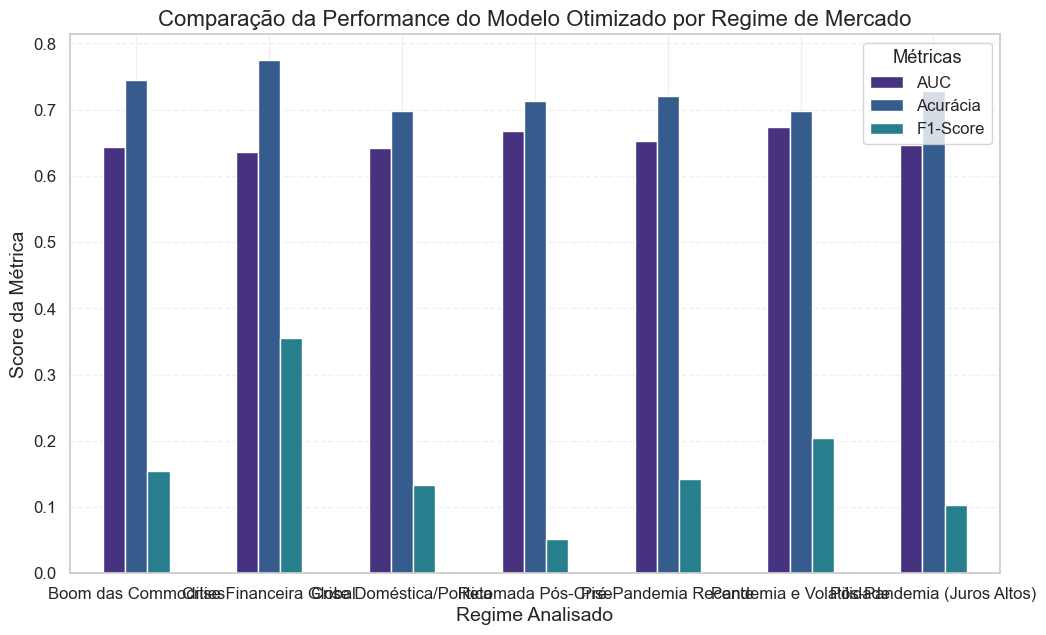

In [15]:
# Desativar os logs detalhados do Optuna para um output mais limpo
optuna.logging.set_verbosity(optuna.logging.WARNING)

def otimizar_e_avaliar_regime(df_completo, nome_regime, data_inicio, meses_teste=6, top_n_features=5):
    """
    Executa um pipeline completo de otimização com Optuna, avaliação
    e extração das features mais importantes para um regime de mercado específico.
    """
    print(f"\n======================================================================")
    print(f"--- Processando Regime: '{nome_regime}' (Início: {data_inicio}) ---")
    print(f"======================================================================")
    
    # 1. FILTRAR E DIVIDIR OS DADOS (sem alterações)
    df_periodo = df_completo[df_completo.index >= data_inicio].copy()
    df_periodo.dropna(inplace=True)
    df_periodo.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_periodo.dropna(inplace=True)
    
    if len(df_periodo) < 252:
        print(f"Aviso: Período com poucas amostras ({len(df_periodo)}). Pulando regime.")
        return None
        
    X = df_periodo.drop(columns=drop_padrão)
    y = df_periodo['target']
    
    data_final = df_periodo.index.max()
    data_corte = data_final - pd.DateOffset(months=meses_teste)
    
    X_train = X[X.index < data_corte]
    X_test = X[X.index >= data_corte]
    y_train = y[y.index < data_corte]
    y_test = y[y.index >= data_corte]

    # 2. PRÉ-PROCESSAMENTO (sem alterações)
    colunas_numericas = X_train.select_dtypes(include=np.number).columns
    colunas_categoricas = X_train.select_dtypes(exclude=np.number).columns
    X_train_categoricas = pd.get_dummies(X_train[colunas_categoricas], drop_first=True).astype(int)
    X_test_categoricas = pd.get_dummies(X_test[colunas_categoricas], drop_first=True).astype(int)
    scaler = StandardScaler()
    X_train_numericas_scaled = scaler.fit_transform(X_train[colunas_numericas])
    X_test_numericas_scaled = scaler.transform(X_test[colunas_numericas])
    X_train_numericas_scaled = pd.DataFrame(X_train_numericas_scaled, index=X_train.index, columns=colunas_numericas)
    X_test_numericas_scaled = pd.DataFrame(X_test_numericas_scaled, index=X_test.index, columns=colunas_numericas)
    X_train_final = pd.concat([X_train_numericas_scaled, X_train_categoricas], axis=1)
    X_test_final = pd.concat([X_test_numericas_scaled, X_test_categoricas], axis=1)
    X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

    # 3. OTIMIZAÇÃO COM OPTUNA (sem alterações)
    def objective(trial):
        params = {
            'objective': 'binary', 'metric': 'auc', 'verbosity': -1,
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'random_state': 42
        }
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train_final, y_train)
        y_pred_proba = model.predict_proba(X_test_final)[:, 1]
        return roc_auc_score(y_test, y_pred_proba)

    print(f"\nIniciando otimização com Optuna para o regime '{nome_regime}'...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # 4. TREINAR MODELO FINAL (sem alterações)
    best_params = study.best_params
    print(f"Melhores parâmetros encontrados: {best_params}")
    
    final_model = lgb.LGBMClassifier(**best_params, random_state=42, verbosity=-1)
    final_model.fit(X_train_final, y_train)
    y_pred = final_model.predict(X_test_final)
    y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]

    # 5. CALCULAR MÉTRICAS DE PERFORMANCE (sem alterações)
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Performance no teste: AUC={auc:.4f}, Acurácia={accuracy:.4f}")

    # --- AJUSTE AQUI ---
    # 6. CALCULAR A IMPORTÂNCIA DAS FEATURES PARA ESTE REGIME
    print("Calculando a importância das features no conjunto de teste...")
    perm_importance_result = permutation_importance(
        estimator=final_model,
        X=X_test_final,
        y=y_test,
        n_repeats=10,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1
    )
    df_importancia = pd.DataFrame(
        {'feature': X_train_final.columns, 'importance_mean': perm_importance_result.importances_mean}
    )
    df_importancia = df_importancia.sort_values(by='importance_mean', ascending=False)
    
    # Extrair a lista das N features mais importantes
    top_features = df_importancia.head(top_n_features)['feature'].tolist()
    
    # 7. RETORNAR OS RESULTADOS, INCLUINDO AS MELHORES FEATURES
    return {
        'Regime': nome_regime,
        'Data Início': data_inicio,
        'AUC': auc,
        'Acurácia': accuracy,
        'F1-Score': f1,
        'Melhores Parâmetros': best_params,
        f'Top_{top_n_features}_Features': top_features # <-- Nova informação retornada
    }

# --- SCRIPT PRINCIPAL ---


# Executar a análise
resultados_finais = []
for nome, data in regimes_para_analise.items():
    resultado = otimizar_e_avaliar_regime(df, nome, data, top_n_features=5) # Definimos que queremos o Top 5
    if resultado:
        resultados_finais.append(resultado)

# Converter os resultados para um DataFrame para fácil visualização
df_resultados = pd.DataFrame(resultados_finais)

# Exibir a tabela final com as melhores features para cada regime
print("\n\n--- COMPARAÇÃO FINAL DOS REGIMES E SUAS PRINCIPAIS FEATURES ---")
pd.set_option('display.max_colwidth', None) # Para garantir que a lista de features não seja cortada
print(df_resultados[['Regime', 'AUC', 'Acurácia', 'Top_5_Features']])


# (Código de plotagem aqui...)

# 4. Plotar os resultados
if not df_resultados.empty:
    df_plot = df_resultados.set_index('Regime')[['AUC', 'Acurácia', 'F1-Score']]
    df_plot.plot(kind='bar', figsize=(12, 7), rot=0)
    plt.title('Comparação da Performance do Modelo Otimizado por Regime de Mercado')
    plt.ylabel('Score da Métrica')
    plt.xlabel('Regime Analisado')
    plt.grid(axis='y', linestyle='--')
    plt.legend(title='Métricas')
    plt.show()

In [ ]:
# Supondo que você já tenha os DataFrames 'df_resultados' (do LightGBM)
# e 'df_resultados_xgb' (do XGBoost)

# Criar um conjunto (set) para armazenar features únicas e evitar duplicatas
all_top_features = set()

# Adicionar as melhores features do LightGBM
for features_list in df_resultados['Top_5_Features']:
    all_top_features.update(features_list)

# Adicionar as melhores features do XGBoost
# (Se ainda não rodou o XGBoost, pode pular esta parte ou usar apenas o df_resultados)
if 'df_resultados_xgb' in locals():
    for features_list in df_resultados_xgb['Top_5_Features']:
        all_top_features.update(features_list)

# Converter o conjunto de volta para uma lista
final_feature_list = list(all_top_features)

print(f"Total de features únicas e de alta importância selecionadas: {len(final_feature_list)}")
print("Lista de Features 'All-Star':")
print(final_feature_list)

XGBoost


--- Processando Regime com XGBoost/Optuna + Feature Selection: 'Boom das Commodities' ---
Iniciando otimização para 'Boom das Commodities' com 100 trials...

--- Resultados Finais para o Regime: 'Boom das Commodities' ---
Melhor AUC encontrado na otimização: 0.7440
              precision    recall  f1-score   support

       Baixa       0.74      1.00      0.85        95
        Alta       1.00      0.03      0.06        34

    accuracy                           0.74       129
   macro avg       0.87      0.51      0.45       129
weighted avg       0.81      0.74      0.64       129


--- Processando Regime com XGBoost/Optuna + Feature Selection: 'Crise Financeira Global' ---
Iniciando otimização para 'Crise Financeira Global' com 100 trials...

--- Resultados Finais para o Regime: 'Crise Financeira Global' ---
Melhor AUC encontrado na otimização: 0.7647
              precision    recall  f1-score   support

       Baixa       0.75      0.99      0.85        95
        Alta       0.

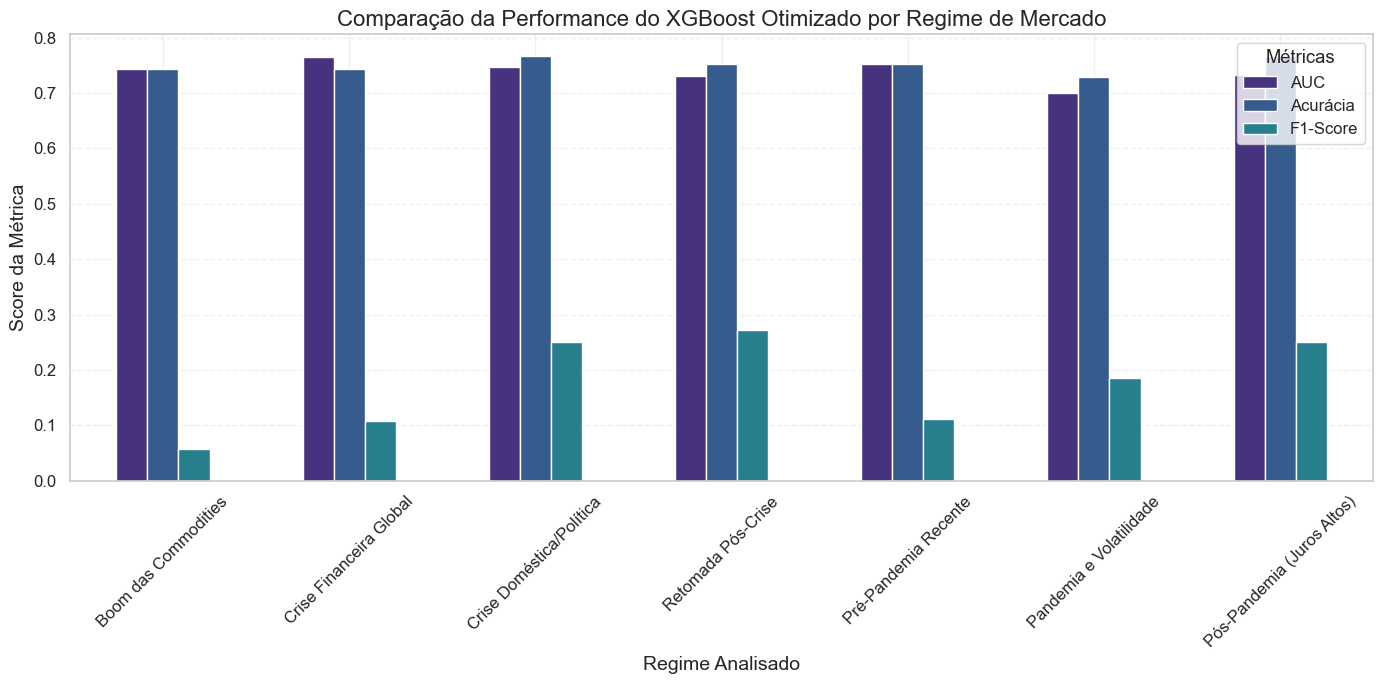

In [19]:
# Configurações iniciais
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

def otimizar_xgb_com_selecao_features(df_completo, nome_regime, data_inicio, meses_teste=6, n_trials_optuna=100):
    """
    Executa um pipeline completo de otimização com Optuna para um XGBoost,
    otimizando hiperparâmetros E selecionando o melhor subconjunto de features.
    """
    print(f"\n======================================================================")
    print(f"--- Processando Regime com XGBoost/Optuna + Feature Selection: '{nome_regime}' ---")
    print(f"======================================================================")

    # 1. FILTRAR E PREPARAR OS DADOS
    df_periodo = df_completo[df_completo.index >= data_inicio].copy()
    df_periodo.dropna(subset=['target'], inplace=True)
    df_periodo.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_periodo.dropna(inplace=True)

    if len(df_periodo) < 100:
        print(f"Aviso: Período '{nome_regime}' com poucas amostras ({len(df_periodo)}). Pulando regime.")
        return None
    
    # Assume que 'final_feature_list' é uma variável global com todas as features candidatas
    features_candidatas = [col for col in final_feature_list if col in df_periodo.columns]
    
    # CORREÇÃO: Usando a lista de features candidatas para definir X
    X = df_periodo[features_candidatas]
    y = df_periodo['target']
    
    data_corte = df_periodo.index.max() - pd.DateOffset(months=meses_teste)
    X_train, X_test = X[X.index < data_corte], X[X.index >= data_corte]
    y_train, y_test = y[y.index < data_corte], y[y.index >= data_corte]

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    # 2. FUNÇÃO OBJECTIVE PARA O OPTUNA
    def objective(trial):
        # A. Optuna seleciona um subconjunto de features
        features_a_usar = [
            feature for feature in features_candidatas 
            if trial.suggest_categorical(f"feature_{feature}", [True, False])
        ]
        
        if not features_a_usar: return 0.0

        X_train_trial = X_train_scaled[features_a_usar]
        X_test_trial = X_test_scaled[features_a_usar]

        # B. Optuna otimiza os hiperparâmetros do XGBoost
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'use_label_encoder': False,
            'verbosity': 0,
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
        }
        model = xgb.XGBClassifier(**params)
        model.fit(X_train_trial, y_train)
        
        y_pred_proba = model.predict_proba(X_test_trial)[:, 1]
        return roc_auc_score(y_test, y_pred_proba)

    # 3. EXECUTAR A OTIMIZAÇÃO
    print(f"Iniciando otimização para '{nome_regime}' com {n_trials_optuna} trials...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)
    
    # 4. TREINAR E AVALIAR O MELHOR MODELO ENCONTRADO
    best_params_raw = study.best_params
    
    best_features = [col.replace('feature_', '') for col, usar in best_params_raw.items() if col.startswith('feature_') and usar]
    best_hyperparams = {k: v for k, v in best_params_raw.items() if not k.startswith('feature_')}
    
    if not best_features:
        print(f"Nenhuma feature selecionada para o regime '{nome_regime}'. Pulando.")
        return None

    X_train_best = X_train_scaled[best_features]
    X_test_best = X_test_scaled[best_features]

    final_model = xgb.XGBClassifier(**best_hyperparams, random_state=42, use_label_encoder=False, verbosity=0)
    final_model.fit(X_train_best, y_train)
    y_pred = final_model.predict(X_test_best)
    y_pred_proba = final_model.predict_proba(X_test_best)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n--- Resultados Finais para o Regime: '{nome_regime}' ---")
    print(f"Melhor AUC encontrado na otimização: {study.best_value:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Baixa', 'Alta']))
    
    return {
        'Regime': nome_regime,
        'AUC': auc,
        'Acurácia': accuracy,
        'F1-Score': f1,
        'Melhores_Features': best_features,
        'Melhores_Hiperparametros': best_hyperparams
    }


# Executar a análise
resultados_finais_xgb = []
for nome, data in regimes_para_analise.items():
    resultado = otimizar_xgb_com_selecao_features(df, nome, data, n_trials_optuna=100) 
    if resultado:
        resultados_finais_xgb.append(resultado)

# Converter os resultados para um DataFrame
if resultados_finais_xgb:
    df_resultados_xgb = pd.DataFrame(resultados_finais_xgb)

    # Exibir a tabela final
    print("\n\n--- COMPARAÇÃO FINAL DOS REGIMES (XGBoost) E SUAS PRINCIPAIS FEATURES ---")
    pd.set_option('display.max_colwidth', None)
    print(df_resultados_xgb[['Regime', 'AUC', 'Acurácia', 'F1-Score', 'Melhores_Features']])

    # Plotar os resultados
    df_plot_xgb = df_resultados_xgb.set_index('Regime')[['AUC', 'Acurácia', 'F1-Score']]
    df_plot_xgb.plot(kind='bar', figsize=(14, 7), rot=45)
    plt.title('Comparação da Performance do XGBoost Otimizado por Regime de Mercado')
    plt.ylabel('Score da Métrica')
    plt.xlabel('Regime Analisado')
    plt.grid(axis='y', linestyle='--')
    plt.legend(title='Métricas')
    plt.tight_layout()
    plt.show()


tensorflow

In [ ]:
# Desativar logs detalhados e avisos para um output mais limpo
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

def otimizar_lstm_com_selecao_features(df_completo, nome_regime, data_inicio, meses_teste=6, n_trials_optuna=50):
    """
    Executa um pipeline completo de otimização com Optuna para uma LSTM,
    otimizando a arquitetura E selecionando o melhor subconjunto de features.
    """
    print(f"\n======================================================================")
    print(f"--- Processando Regime com LSTM/Optuna: '{nome_regime}' ---")
    print(f"======================================================================")

    # --- Bloco de preparação de dados (sem alterações) ---
    df_periodo = df_completo[df_completo.index >= data_inicio].copy()
    df_periodo.dropna(subset=['target'], inplace=True)
    df_periodo.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_periodo.dropna(inplace=True)

    if len(df_periodo) < 100:
        print(f"Aviso: Período '{nome_regime}' com poucas amostras ({len(df_periodo)}). Pulando regime.")
        return None
        
    # Assume que 'final_feature_list' é uma variável global com todas as features candidatas
    features_candidatas = [col for col in final_feature_list if col in df_periodo.columns]
    X = df_periodo[features_candidatas]
    y = df_periodo['target']
    
    data_corte = df_periodo.index.max() - pd.DateOffset(months=meses_teste)
    X_train, X_test = X[X.index < data_corte], X[X.index >= data_corte]
    y_train, y_test = y[y.index < data_corte], y[y.index >= data_corte]

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    def create_sequences(X, y, time_steps=10):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X.iloc[i:(i + time_steps)].values)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    # --- Função objective para o Optuna (sem alterações) ---
    def objective(trial):
        features_a_usar = [
            feature for feature in features_candidatas 
            if trial.suggest_categorical(f"feature_{feature}", [True, False])
        ]
        
        if not features_a_usar: return 0.0

        X_train_trial = X_train_scaled[features_a_usar]
        X_test_trial = X_test_scaled[features_a_usar]

        time_steps = trial.suggest_int('time_steps', 5, 20)
        lstm_units = trial.suggest_int('lstm_units', 32, 128)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        
        X_train_seq, y_train_seq = create_sequences(X_train_trial, y_train, time_steps)
        X_test_seq, y_test_seq = create_sequences(X_test_trial, y_test, time_steps)

        if len(X_train_seq) == 0 or len(X_test_seq) == 0: return 0.0
        
        tf.random.set_seed(42)
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(time_steps, X_train_seq.shape[2])),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ])
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['AUC'])
        model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0, shuffle=False)
        
        y_pred_proba = model.predict(X_test_seq, verbose=0).flatten()
        
        if len(y_test_seq) != len(y_pred_proba): return 0.0
        
        return roc_auc_score(y_test_seq, y_pred_proba)

    # --- Otimização com Optuna ---
    print(f"Iniciando otimização da LSTM para '{nome_regime}' com {n_trials_optuna} trials...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)

    # --- 3. CORREÇÃO: TREINAR E AVALIAR O MELHOR MODELO ENCONTRADO ---
    print("\nOtimização concluída. Treinando o melhor modelo para avaliação final...")
    best_params = study.best_params
    
    best_features_names = [col.replace('feature_', '') for col, usar in best_params.items() if col.startswith('feature_') and usar]
    best_hiperparams = {k: v for k, v in best_params.items() if not k.startswith('feature_')}

    if not best_features_names:
        print(f"Nenhuma feature selecionada para o regime '{nome_regime}'. Pulando.")
        return None

    X_train_best = X_train_scaled[best_features_names]
    X_test_best = X_test_scaled[best_features_names]
    best_time_steps = best_hiperparams['time_steps']
    
    X_train_seq, y_train_seq = create_sequences(X_train_best, y_train, best_time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_best, y_test, best_time_steps)
    
    tf.random.set_seed(42)
    final_model = Sequential([
        LSTM(units=best_hiperparams['lstm_units'], input_shape=(best_time_steps, X_train_seq.shape[2])),
        Dropout(rate=best_hiperparams['dropout_rate']),
        Dense(1, activation='sigmoid')
    ])
    final_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=best_hiperparams['learning_rate']), metrics=['AUC'])
    final_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0, shuffle=False)
    
    y_pred_proba = final_model.predict(X_test_seq, verbose=0).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    auc = roc_auc_score(y_test_seq, y_pred_proba)
    accuracy = accuracy_score(y_test_seq, y_pred)
    f1 = f1_score(y_test_seq, y_pred)
    
    print(f"\n--- Resultados Finais para o Regime: '{nome_regime}' ---")
    print(f"Melhor AUC encontrado na otimização: {study.best_value:.4f}")
    print(classification_report(y_test_seq, y_pred, target_names=['Baixa', 'Alta']))
    
    return {
        'Regime': nome_regime,
        'AUC': auc,
        'Acurácia': accuracy,
        'F1-Score': f1,
        'Melhores_Features': best_features_names,
        'Melhores_Hiperparametros': best_hiperparams
    }

# --- SCRIPT PRINCIPAL CORRIGIDO ---
# Supondo que 'df', 'final_feature_list' e 'regimes_para_analise' estejam definidos.
# ...

# Executar a análise
resultados_finais_lstm = []
for nome, data in regimes_para_analise.items():
    # CORREÇÃO: Chamando a função correta
    resultado = otimizar_lstm_com_selecao_features(df, nome, data, n_trials_optuna=50) 
    if resultado:
        resultados_finais_lstm.append(resultado)

# Converter os resultados para um DataFrame
if resultados_finais_lstm:
    df_resultados_lstm = pd.DataFrame(resultados_finais_lstm)

    # Exibir a tabela final
    print("\n\n--- COMPARAÇÃO FINAL DOS REGIMES (LSTM) E SUAS PRINCIPAIS FEATURES ---")
    pd.set_option('display.max_colwidth', None)
    # CORREÇÃO: Acessando as colunas corretas
    print(df_resultados_lstm[['Regime', 'AUC', 'Acurácia', 'F1-Score', 'Melhores_Features']])

    # Plotar os resultados
    df_plot_lstm = df_resultados_lstm.set_index('Regime')[['AUC', 'Acurácia', 'F1-Score']]
    df_plot_lstm.plot(kind='bar', figsize=(14, 7), rot=45)
    plt.title('Comparação da Performance do Modelo LSTM Otimizado por Regime de Mercado')
    plt.ylabel('Score da Métrica')
    plt.xlabel('Regime Analisado')
    plt.grid(axis='y', linestyle='--')
    plt.legend(title='Métricas')
    plt.tight_layout()
    plt.show()


--- Processando Regime com LSTM/Optuna: 'Boom das Commodities' ---
Iniciando otimização da LSTM para 'Boom das Commodities' com 50 trials...

Otimização concluída. Treinando o melhor modelo para avaliação final...

--- Resultados Finais para o Regime: 'Boom das Commodities' ---
Melhor AUC encontrado na otimização: 0.6826
              precision    recall  f1-score   support

       Baixa       0.73      0.99      0.84        89
        Alta       0.00      0.00      0.00        32

    accuracy                           0.73       121
   macro avg       0.37      0.49      0.42       121
weighted avg       0.54      0.73      0.62       121


--- Processando Regime com LSTM/Optuna: 'Crise Financeira Global' ---
Iniciando otimização da LSTM para 'Crise Financeira Global' com 50 trials...

Otimização concluída. Treinando o melhor modelo para avaliação final...

--- Resultados Finais para o Regime: 'Crise Financeira Global' ---
Melhor AUC encontrado na otimização: 0.7543
              pr

LogisticRegression

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)



def otimizar_logistica_com_selecao_features(df_completo, nome_regime, data_inicio, meses_teste=6, n_trials_optuna=100):
    """
    Executa um pipeline completo de otimização com Optuna para uma Regressão Logística,
    otimizando hiperparâmetros E selecionando o melhor subconjunto de features.
    """
    print(f"\n======================================================================")
    print(f"--- Processando Regime com Regressão Logística/Optuna: '{nome_regime}' ---")
    print(f"======================================================================")

    # 1. FILTRAR E PREPARAR OS DADOS
    df_periodo = df_completo[df_completo.index >= data_inicio].copy()
    # Assume que a limpeza de NaNs e Infs já foi feita ou será feita aqui
    df_periodo.dropna(subset=['target'], inplace=True)
    df_periodo.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_periodo.dropna(inplace=True)

    if len(df_periodo) < 100: # Mínimo de amostras para ser viável
        print(f"Aviso: Período '{nome_regime}' com poucas amostras ({len(df_periodo)}). Pulando regime.")
        return None
    
    # Assume que 'final_feature_list' é uma variável global ou passada como argumento
    # contendo todas as features candidatas.
    features_candidatas = [col for col in final_feature_list if col in df_periodo.columns]
    
    # X = df_periodo.drop(columns=drop_padrão)
    X = df_periodo[final_feature_list]
    y = df_periodo['target']
    
    data_corte = df_periodo.index.max() - pd.DateOffset(months=meses_teste)
    X_train, X_test = X[X.index < data_corte], X[X.index >= data_corte]
    y_train, y_test = y[y.index < data_corte], y[y.index >= data_corte]

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    # 2. FUNÇÃO OBJECTIVE PARA O OPTUNA
    def objective(trial):
        # A. Optuna seleciona um subconjunto de features
        features_a_usar = [
            feature for feature in features_candidatas 
            if trial.suggest_categorical(f"feature_{feature}", [True, False])
        ]
        
        if not features_a_usar: return 0.0 # Evita treinar sem features

        X_train_trial = X_train_scaled[features_a_usar]
        X_test_trial = X_test_scaled[features_a_usar]

        # B. Optuna otimiza os hiperparâmetros da Regressão Logística
        c_param = trial.suggest_float('C', 1e-4, 1e2, log=True)
        penalty_param = trial.suggest_categorical('penalty', ['l1', 'l2'])
        
        # O solver 'saga' é compatível com ambas as penalidades l1 e l2
        solver_param = 'saga'

        # C. Treinar e avaliar o modelo
        model = LogisticRegression(
            C=c_param,
            penalty=penalty_param,
            solver=solver_param,
            class_weight='balanced', # Crucial para dados financeiros desbalanceados
            random_state=42,
            max_iter=1000 # Aumentar para garantir convergência do 'saga'
        )
        model.fit(X_train_trial, y_train)
        
        y_pred_proba = model.predict_proba(X_test_trial)[:, 1]
        return roc_auc_score(y_test, y_pred_proba)

    # 3. EXECUTAR A OTIMIZAÇÃO
    print(f"Iniciando otimização para '{nome_regime}' com {n_trials_optuna} trials...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials_optuna)
    
    # 4. TREINAR E AVALIAR O MELHOR MODELO ENCONTRADO
    best_params = study.best_params
    
    best_features = [col.replace('feature_', '') for col, usar in best_params.items() if col.startswith('feature_') and usar]
    
    if not best_features:
        print(f"Nenhuma feature selecionada para o regime '{nome_regime}'. Pulando.")
        return None

    # Recriar os dados de treino/teste com as melhores features
    X_train_best = X_train_scaled[best_features]
    X_test_best = X_test_scaled[best_features]

    # Treinar o modelo final com os melhores hiperparâmetros
    final_model = LogisticRegression(
        C=best_params.get('C'),
        penalty=best_params.get('penalty'),
        solver='saga',
        class_weight='balanced',
        random_state=42,
        max_iter=1300
    )
    final_model.fit(X_train_best, y_train)
    y_pred = final_model.predict(X_test_best)
    y_pred_proba = final_model.predict_proba(X_test_best)[:, 1]

    # Calcular as métricas de performance
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n--- Resultados Finais para o Regime: '{nome_regime}' ---")
    print(f"Melhor AUC encontrado na otimização: {study.best_value:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Baixa', 'Alta']))
    
    return {
        'Regime': nome_regime,
        'AUC': auc,
        'Acurácia': accuracy,
        'F1-Score': f1,
        'Top_Features': best_features,
        'Melhores_Hiperparametros': {k: v for k, v in best_params.items() if not k.startswith('feature_')}
    }


resultados_finais = []
for nome, data in regimes_para_analise.items():
    # A função agora se chama otimizar_logistica_com_selecao_features
    resultado = otimizar_logistica_com_selecao_features(df, nome, data, n_trials_optuna=100)
    if resultado:
        resultados_finais.append(resultado)

# Converter os resultados para um DataFrame para fácil visualização
if resultados_finais:
    df_resultados = pd.DataFrame(resultados_finais)
    pd.set_option('display.max_colwidth', None)
    
    print("\n\n--- COMPARAÇÃO FINAL DOS REGIMES (Regressão Logística) ---")
    print(df_resultados[['Regime', 'AUC', 'Acurácia', 'F1-Score', 'Top_Features']])

    # Plotar os resultados
    df_plot = df_resultados.set_index('Regime')[['AUC', 'Acurácia', 'F1-Score']]
    df_plot.plot(kind='bar', figsize=(14, 7), rot=45)
    plt.title('Comparação da Performance da Regressão Logística por Regime de Mercado')
    plt.ylabel('Score da Métrica')
    plt.xlabel('Regime Analisado')
    plt.grid(axis='y', linestyle='--')
    plt.legend(title='Métricas')
    plt.tight_layout()
    plt.show()
